In [3]:
import pandas as pd

# --- Define the filenames ---
noah_gws_file = 'NOAH_GWS_Final_Results_per_Pixel_cm.csv'
clsm_gws_file = 'CLSM_GWS_Final_Results_per_Pixel_cm.csv'
vic_gws_file = 'VIC_GWS_Final_Results_per_Pixel_cm.csv'

# --- Load the datasets ---
print("Loading the three individual GWS result files...")
df_noah = pd.read_csv(noah_gws_file)
df_clsm = pd.read_csv(clsm_gws_file)
df_vic = pd.read_csv(vic_gws_file)

# --- Ensure 'time' column is in datetime format ---
for df in [df_noah, df_clsm, df_vic]:
    df['time'] = pd.to_datetime(df['time'])

# --- Prepare each DataFrame for the merge ---
print("Preparing and renaming columns...")
merge_keys = ['time', 'lat', 'lon']

# THE FIX: Select all GRACE columns along with the GWS column for NOAH
df_noah_subset = df_noah[merge_keys + ['lwe_thickness_cm', 'uncertainty_cm', 'scale_factor', 'GWS_anomaly_cm']].rename(columns={
    'GWS_anomaly_cm': 'GWS_noah_cm'
})

# Select and rename the GWS column for CLSM
df_clsm_subset = df_clsm[merge_keys + ['GWS_anomaly_cm']].rename(columns={
    'GWS_anomaly_cm': 'GWS_clsm_cm'
})

# Select and rename the GWS column for VIC
df_vic_subset = df_vic[merge_keys + ['GWS_anomaly_cm']].rename(columns={
    'GWS_anomaly_cm': 'GWS_vic_cm'
})


# --- Merge the three DataFrames ---
print("Merging the GWS results...")
# Start with the NOAH subset, which now includes all GRACE data
merged_gws_df = df_noah_subset

# Merge with CLSM
merged_gws_df = pd.merge(merged_gws_df, df_clsm_subset, on=merge_keys, how='left')

# Merge with VIC
merged_gws_df = pd.merge(merged_gws_df, df_vic_subset, on=merge_keys, how='left')


# --- Save and preview the result ---
output_filename = 'GWS_individual_models_merged.csv'
merged_gws_df.to_csv(output_filename, index=False)

print(f"\n✅ Merge complete! The combined GWS dataset has been saved to '{output_filename}'")
print("\n--- Preview of the Merged GWS Data ---")
print(merged_gws_df.head())

Loading the three individual GWS result files...
Preparing and renaming columns...
Merging the GWS results...

✅ Merge complete! The combined GWS dataset has been saved to 'GWS_individual_models_merged.csv'

--- Preview of the Merged GWS Data ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  GWS_noah_cm  GWS_clsm_cm  GWS_vic_cm  
0      0.967227    -7.511963    -9.681166   -7.263814  
1      1.054784    -5.091877   -10.425582   -8.634174  
2      1.054784    -6.963112   -10.425582   -8.634174  
3      0.955446    -6.963112   -10.425582   -8.634174  
4      1.280962    -6.792599     1

In [5]:
import pandas as pd

# --- Step 1: Load the merged file ---
gws_merged_file = 'GWS_individual_models_merged.csv'
final_df = pd.read_csv(gws_merged_file)

# --- Step 2: Define the GWS columns to average ---
gws_cols_to_average = ['GWS_noah_cm', 'GWS_clsm_cm', 'GWS_vic_cm']

# --- Step 3: Calculate the average GWS ---
print("Calculating the average of the individual GWS results...")
# .mean(axis=1) calculates the average horizontally across the columns for each row
final_df['GWS_output_ensemble_cm'] = final_df[gws_cols_to_average].mean(axis=1)

# --- Step 4: Save the final result ---
output_filename = 'GWS_Output_Ensemble_Final_Results_cm.csv'
final_df.to_csv(output_filename, index=False)
print(f"✅ Final results saved successfully to '{output_filename}'")


# --- Step 5: Preview the result ---
print("\n--- Preview of the new average GWS column ---")
print(final_df.head())

Calculating the average of the individual GWS results...
✅ Final results saved successfully to 'GWS_Output_Ensemble_Final_Results_cm.csv'

--- Preview of the new average GWS column ---
                  time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0  2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1  2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2  2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3  2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4  2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  GWS_noah_cm  GWS_clsm_cm  GWS_vic_cm  GWS_output_ensemble_cm  
0      0.967227    -7.511963    -9.681166   -7.263814               -8.152314  
1      1.054784    -5.091877   -10.425582   -8.634174               -8.050544  
2      1.054784    -6.963112   -10.425582   -8.634174               -8.674290  
3      0.955446    -6.963112   -10.425582   -8.634

Generating the final time-series plot...


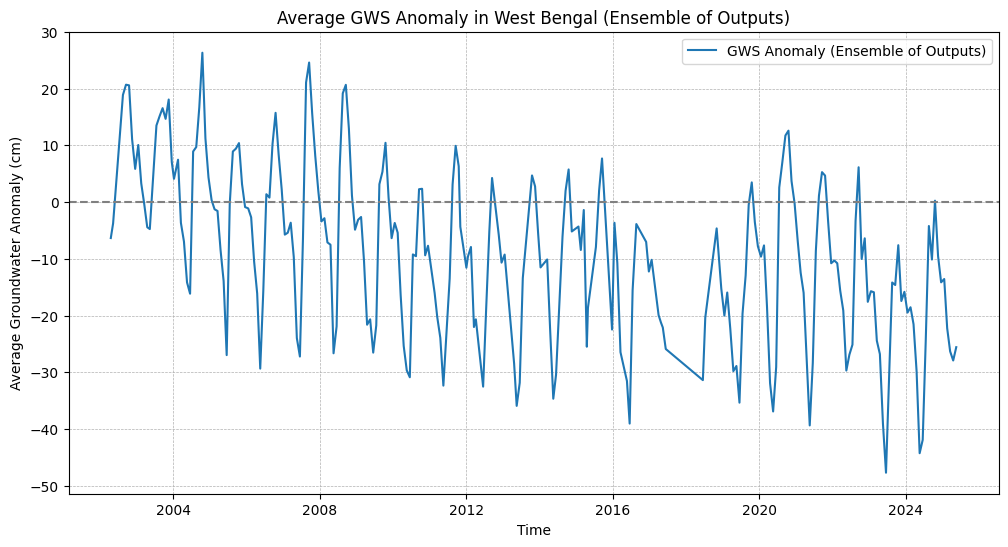

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load your final ensemble results file ---
final_file = 'GWS_Output_Ensemble_Final_Results_cm.csv'
final_df = pd.read_csv(final_file)
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Aggregate to a single basin-wide time series ---
# This calculates the average GWS anomaly across all grid cells for each month.
gws_basin_avg = final_df.groupby('time')['GWS_output_ensemble_cm'].mean().reset_index()

# --- Step 3: Create the plot ---
print("Generating the final time-series plot...")

plt.figure(figsize=(12, 6))

# Plot the data
plt.plot(gws_basin_avg['time'], gws_basin_avg['GWS_output_ensemble_cm'], label='GWS Anomaly (Ensemble of Outputs)')

# Add a baseline and formatting
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Average GWS Anomaly in West Bengal (Ensemble of Outputs)')
plt.xlabel('Time')
plt.ylabel('Average Groundwater Anomaly (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Display the plot
plt.show()

Generating the final time-series plot with missing data markers...


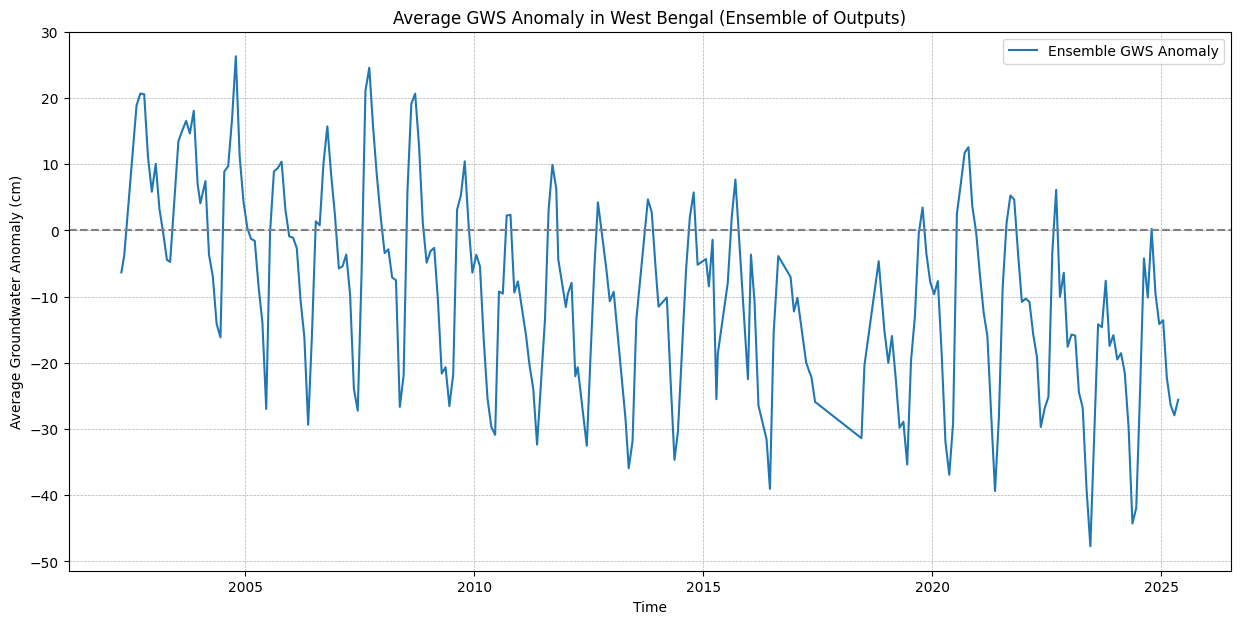

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Step 1: Load your final ensemble results file ---
# Using the "Ensemble of Outputs" file as an example
final_file = 'GWS_Output_Ensemble_Final_Results_cm.csv' 
final_df = pd.read_csv(final_file)
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Aggregate to a single basin-wide time series ---
# This calculates the average GWS anomaly across all grid cells for each month.
gws_basin_avg = final_df.groupby('time')['GWS_output_ensemble_cm'].mean().reset_index()

# --- Step 3: Find the missing data points ---
# Create a new DataFrame that contains only the rows where the GWS value is NaN
missing_data = gws_basin_avg[gws_basin_avg['GWS_output_ensemble_cm'].isna()]


# --- Step 4: Create the plot ---
print("Generating the final time-series plot with missing data markers...")

plt.figure(figsize=(15, 7)) # Made the plot wider for better visibility

# Plot the main data line. This will have gaps where data is missing.
plt.plot(gws_basin_avg['time'], gws_basin_avg['GWS_output_ensemble_cm'], label='Ensemble GWS Anomaly')

# Plot a horizontal line at y=0 to serve as a baseline
plt.axhline(y=0, color='gray', linestyle='--')

# --- Step 5: Add markers and text for each missing data point ---
if not missing_data.empty:
    # Plot red 'X' markers on the baseline for each missing month
    plt.scatter(missing_data['time'], [0] * len(missing_data), color='red', marker='x', s=100, zorder=5, label='Missing GRACE Data')
    
    # Optional: Add text labels above the markers if there are only a few gaps
    # If there are many gaps, this can make the plot look cluttered.
    # for index, row in missing_data.iterrows():
    #     plt.text(row['time'], 5, 'NaN', color='red', ha='center', fontsize=9)


# --- Step 6: Add a title and labels ---
plt.title('Average GWS Anomaly in West Bengal (Ensemble of Outputs)')
plt.xlabel('Time')
plt.ylabel('Average Groundwater Anomaly (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Improve date formatting on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Display the plot
plt.show()

Generating the final discontinuous smooth curve plot...


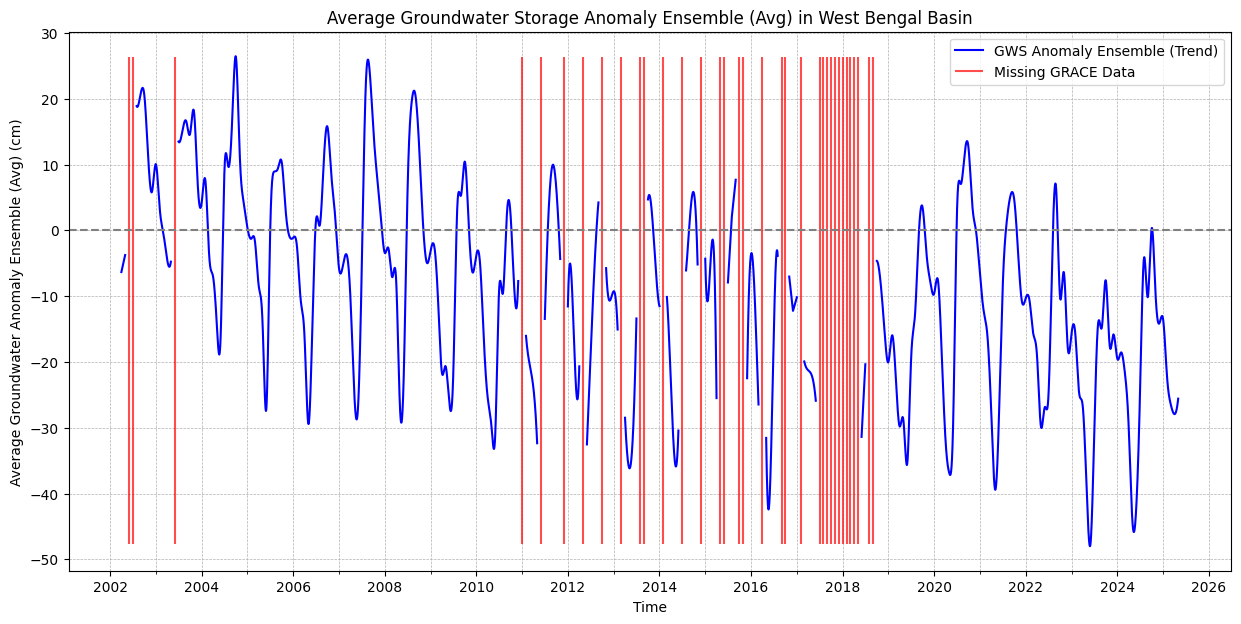

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import CubicSpline

# --- Steps 1-4: Load and prepare the data (these are unchanged) ---
final_df = pd.read_csv('GWS_Output_Ensemble_Final_Results_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

gws_basin_avg = final_df.groupby('time')['GWS_output_ensemble_cm'].mean().reset_index()

gws_basin_avg['time'] = gws_basin_avg['time'].dt.to_period('M').dt.start_time

full_date_range = pd.date_range(
    start=gws_basin_avg['time'].min(),
    end=gws_basin_avg['time'].max(),
    freq='MS'
)
full_date_df = pd.DataFrame({'time': full_date_range})

plot_df = pd.merge(full_date_df, gws_basin_avg, on='time', how='left')


# --- Step 5: Create the discontinuous smooth curve plot ---
print("Generating the final discontinuous smooth curve plot...")

plt.figure(figsize=(15, 7))
ax = plt.gca()

# Separate data into points that exist and points that are missing
has_data = plot_df.dropna().sort_values(by='time').drop_duplicates(subset='time')
missing_data = plot_df[plot_df['GWS_output_ensemble_cm'].isna()]

# --- THE FIX: Identify contiguous blocks of data ---
# A new block is identified where the gap between dates is more than a month
has_data['block'] = (has_data['time'].diff() > pd.Timedelta('32 days')).cumsum()

# Loop through each block and plot it as a separate smooth curve
for block_id, group in has_data.groupby('block'):
    # Spline interpolation needs at least a few points to work
    if len(group) > 3:
        # Convert dates to a numerical format for interpolation
        x_numeric = group['time'].astype(np.int64) // 10**9
        y = group['GWS_output_ensemble_cm']
        
        spline = CubicSpline(x_numeric, y)
        
        x_numeric_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 100 * len(group))
        x_datetime_smooth = pd.to_datetime(x_numeric_smooth, unit='s')
        
        y_smooth = spline(x_numeric_smooth)
        
        # Use the same color for all segments, but don't repeat the label
        ax.plot(x_datetime_smooth, y_smooth, color='blue', label='_nolegend_' if block_id > 0 else 'GWS Anomaly Ensemble (Trend)')
    elif len(group) > 1: # If too few points for a spline, draw a straight line
        ax.plot(group['time'], group['GWS_output_ensemble_cm'], color='blue', label='_nolegend_' if block_id > 0 else 'GWS Anomaly Ensemble (Trend)')

# --- Plot the missing data as red vertical lines ---
if not missing_data.empty:
    data_min = has_data['GWS_output_ensemble_cm'].min()
    data_max = has_data['GWS_output_ensemble_cm'].max()
    ax.vlines(
        missing_data['time'],
        ymin=data_min if pd.notna(data_min) else -1,
        ymax=data_max if pd.notna(data_max) else 1,
        color='red',
        linestyle='-',
        linewidth=1.5,
        alpha=0.7,
        label='Missing GRACE Data'
    )

# Add a baseline and formatting
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_title('Average Groundwater Storage Anomaly Ensemble (Avg) in West Bengal Basin')
ax.set_xlabel('Time')
ax.set_ylabel('Average Groundwater Anomaly Ensemble (Avg) (cm)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Improve date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

In [8]:
import pandas as pd

# Load one of your final GWS files (either an individual one or an ensemble one)
df = pd.read_csv('GWS_Ensemble_Final_Results_cm.csv')

# Check if the main GRACE column has any NaN (missing) values
missing_values_exist = df['lwe_thickness_cm'].isna().any()

if missing_values_exist:
    print("Diagnosis: NaN values ARE present. The issue might be with the plotting code.")
else:
    print("Diagnosis: No NaN values found. This confirms the data was interpolated at an earlier stage.")

Diagnosis: No NaN values found. This confirms the data was interpolated at an earlier stage.
